In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
df = pd.read_csv('/content/drive/My Drive/ML Project/Nikki/Copy of TIDY_unclean_1.csv')

<ipython-input-19-7c7ec44dea65>:1: DtypeWarning: Columns (35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/My Drive/ML Project/Nikki/Copy of TIDY_unclean_1.csv')


In [20]:
print(df.columns.tolist())

['projectid', 'teacher_acctid_x', 'schoolid', 'school_ncesid', 'school_latitude', 'school_longitude', 'school_city', 'school_state', 'school_zip', 'school_metro', 'school_district', 'school_county', 'school_charter', 'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp', 'school_charter_ready_promise', 'teacher_prefix', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'fulfillment_labor_materials', 'total_price_excluding_optional_support', 'total_price_including_optional_support', 'students_reached', 'eligible_double_your_impact_match', 'eligible_almost_home_match', 'date_posted', 'is_exciting', 'at_least_1_teacher_referred_donor', 'fully_funded', 'at_least_1_green_donation', 'great_chat', 'three_or_more_non_teacher_referred_donors', 'one_non_teacher_referred_donor_giving_100_plus', 'donation_from_thoughtful_donor', 'g

In [21]:
df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')

# Filter out any rows posted in 2014 or later
df = df[df['date_posted'] < pd.Timestamp('2014-01-01')]

# Calculate ratio of amount raised
df['amount_raised_ratio'] = df['total_donation_amount'].fillna(0) / df['total_price_including_optional_support']
df['amount_raised_ratio'] = df['amount_raised_ratio'].clip(upper=1.0)

# Define columns to keep
selected_columns = [
    'school_state',  # renamed as 'state'
    'school_charter',
    'primary_focus_subject',
    'resource_type',
    'poverty_level',
    'grade_level',
    'eligible_double_your_impact_match',
    'eligible_almost_home_match',
    'fully_funded',           # will rename to is_fully_funded
    'amount_raised_ratio',    # new feature
    'projectid',              # keep for reference (not ML input)
    'date_posted'             # keep for date-based split (not ML input)
]

df_filtered = df[selected_columns]

print(f"Filtered data shape: {df_filtered.shape}")
df_filtered.head()

Filtered data shape: (619326, 12)


<ipython-input-21-dbd252e752ef>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['amount_raised_ratio'] = df['total_donation_amount'].fillna(0) / df['total_price_including_optional_support']
<ipython-input-21-dbd252e752ef>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['amount_raised_ratio'] = df['amount_raised_ratio'].clip(upper=1.0)


,school_state,school_charter,primary_focus_subject,resource_type,poverty_level,grade_level,eligible_double_your_impact_match,eligible_almost_home_match,fully_funded,amount_raised_ratio,projectid,date_posted
0,NY,f,Other,Supplies,highest poverty,Grades 6-8,f,f,t,0.819995,77558a6eda151deee9a00553f7fccfc7,2002-09-13
1,NY,f,Literacy,Books,highest poverty,Grades 9-12,f,f,t,0.819995,e139df754a873a62d93daa56acbf8040,2002-09-13
2,NY,f,Early Development,Supplies,moderate poverty,Grades 3-5,f,f,t,0.819995,82e536f14eadf2671a70e03416f695a3,2002-09-16
3,NY,f,Other,Supplies,highest poverty,Grades 3-5,f,f,t,0.820000,8a8411fa1c3bc55c1481978c5e2e6386,2002-09-17
4,NY,f,Economics,Technology,highest poverty,Grades 9-12,f,f,t,0.901346,e02da37beb332eb66c2d2ba989c597ad,2002-09-17


In [22]:
df_filtered['amount_raised_ratio'].describe()

,amount_raised_ratio
count,619081.000000
mean,0.604673
std,0.362837
min,0.000000
25%,0.129874
50%,0.820690
75%,0.850000
max,1.000000


In [23]:
print(df_filtered.shape)
df_cleaned = df_filtered.dropna()
print(df_cleaned.shape)

# Convert t/f → 1/0 for 3 standard columns
binary_cols = [
    'school_charter',
    'eligible_double_your_impact_match',
    'eligible_almost_home_match'
]

for col in binary_cols:
    df_cleaned[col] = df_cleaned[col].map({'t': 1, 'f': 0})

# Convert t/f → 0/1 for the label (fully_funded: 't' means funded → now label 0)
df_cleaned['fully_funded'] = df_cleaned['fully_funded'].map({'t': 0, 'f': 1})

df_cleaned.head()


(619326, 12)
(619033, 12)


<ipython-input-23-797c46bd9c07>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].map({'t': 1, 'f': 0})
<ipython-input-23-797c46bd9c07>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = df_cleaned[col].map({'t': 1, 'f': 0})
<ipython-input-23-797c46bd9c07>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

,school_state,school_charter,primary_focus_subject,resource_type,poverty_level,grade_level,eligible_double_your_impact_match,eligible_almost_home_match,fully_funded,amount_raised_ratio,projectid,date_posted
0,NY,0,Other,Supplies,highest poverty,Grades 6-8,0,0,0,0.819995,77558a6eda151deee9a00553f7fccfc7,2002-09-13
1,NY,0,Literacy,Books,highest poverty,Grades 9-12,0,0,0,0.819995,e139df754a873a62d93daa56acbf8040,2002-09-13
2,NY,0,Early Development,Supplies,moderate poverty,Grades 3-5,0,0,0,0.819995,82e536f14eadf2671a70e03416f695a3,2002-09-16
3,NY,0,Other,Supplies,highest poverty,Grades 3-5,0,0,0,0.820000,8a8411fa1c3bc55c1481978c5e2e6386,2002-09-17
4,NY,0,Economics,Technology,highest poverty,Grades 9-12,0,0,0,0.901346,e02da37beb332eb66c2d2ba989c597ad,2002-09-17


In [24]:
df_gdp = pd.read_csv('/content/drive/My Drive/ML Project/Nikki/SASUMMARY__ALL_AREAS_1998_2024.csv')
df_gdp_filtered = df_gdp[df_gdp['Description'] == ' Gross domestic product (GDP) ']

df_gdp_filtered = df_gdp_filtered.drop(['GeoFIPS', 'Region', 'TableName', 'LineCode', 'IndustryClassification'], axis=1)
df_gdp_filtered = df_gdp_filtered.drop(3, axis=0)
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands, U.S.": "VI",
}
df_gdp_filtered['GeoName'] = df_gdp_filtered['GeoName'].replace(us_state_to_abbrev)

df_gdp_filtered.head()

,GeoName,Description,Unit,1998,1999,2000,2001,2002,2003,2004,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
18,AL,Gross domestic product (GDP),Millions of current dollars,110838.8,116514.3,120522.6,123534.5,128380.9,135212.6,148379.1,...,203113.3,208824.3,216615.5,226263.8,234798.2,235325.3,260018.4,284949.1,304935.6,321237.6
33,AK,Gross domestic product (GDP),Millions of current dollars,24387.8,24920.4,26934,28660.9,29884.5,32115.8,35389.5,...,51574.2,51121.8,53550.9,54762,54549.6,51283.4,58943.5,66271.9,68056,69969
48,AZ,Gross domestic product (GDP),Millions of current dollars,144393.2,156442.1,165735.6,172899.6,180844.5,194318,207246.3,...,298942.2,313787.1,333099,353671,375376.7,388956.7,436778.6,484052.2,522767.2,552167
63,AR,Gross domestic product (GDP),Millions of current dollars,62852,67279,69176.3,71099.6,74453.1,79009.7,85928.6,...,118573.6,120987.4,123882.6,129213.8,132625.8,136198.4,154052.5,168605.8,178606.4,188723.1
78,CA,Gross domestic product (GDP),Millions of current dollars,1143672.5,1239773.5,1354791.3,1373270.8,1419321.8,1498578,1585081.4,...,2487156.4,2586485.2,2740550.3,2899530.9,3068629.7,3076755.1,3423958.3,3660415.7,3870378.9,4103123.6


In [25]:
# Extract the year from the date_posted column
df_cleaned['year_posted'] = df_cleaned['date_posted'].dt.year

# Melt the GDP dataframe so years become rows
df_gdp_melted = df_gdp_filtered.melt(
    id_vars=['GeoName'],
    value_vars=[str(year) for year in range(2002, 2014)],
    var_name='year_posted',
    value_name='state_gdp'
)

# Convert year_posted to numeric for matching
df_gdp_melted['year_posted'] = df_gdp_melted['year_posted'].astype(int)

# Merge GDP values into df_filtered
df_merged = df_cleaned.merge(
    df_gdp_melted,
    how='left',
    left_on=['school_state', 'year_posted'],
    right_on=['GeoName', 'year_posted']
)

# Drop GeoName column after merge if desired
df_merged = df_merged.drop(columns=['GeoName'])
df_merged.head()

<ipython-input-25-bb18aec9ee90>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['year_posted'] = df_cleaned['date_posted'].dt.year


,school_state,school_charter,primary_focus_subject,resource_type,poverty_level,grade_level,eligible_double_your_impact_match,eligible_almost_home_match,fully_funded,amount_raised_ratio,projectid,date_posted,year_posted,state_gdp
0,NY,0,Other,Supplies,highest poverty,Grades 6-8,0,0,0,0.819995,77558a6eda151deee9a00553f7fccfc7,2002-09-13,2002,885386.2
1,NY,0,Literacy,Books,highest poverty,Grades 9-12,0,0,0,0.819995,e139df754a873a62d93daa56acbf8040,2002-09-13,2002,885386.2
2,NY,0,Early Development,Supplies,moderate poverty,Grades 3-5,0,0,0,0.819995,82e536f14eadf2671a70e03416f695a3,2002-09-16,2002,885386.2
3,NY,0,Other,Supplies,highest poverty,Grades 3-5,0,0,0,0.820000,8a8411fa1c3bc55c1481978c5e2e6386,2002-09-17,2002,885386.2
4,NY,0,Economics,Technology,highest poverty,Grades 9-12,0,0,0,0.901346,e02da37beb332eb66c2d2ba989c597ad,2002-09-17,2002,885386.2


In [26]:
df_merged = df_merged.drop(columns = ['state_gdp'])

In [27]:
# Ensure datetime format
df_merged['date_posted'] = pd.to_datetime(df_merged['date_posted'], errors='coerce')

# Step 1: Sort by time
df_sorted = df_merged.sort_values('date_posted')

# Step 2: Get 80% split index
split_index = int(0.8 * len(df_sorted))

# Step 3: Get the cutoff date at that index
cutoff_date = df_sorted.iloc[split_index]['date_posted']

# Step 4: Create masks using cutoff_date
train_mask = df_merged['date_posted'] < cutoff_date
test_mask = ~train_mask

# print the cutoff
print("Cutoff date for 80/20 split:", cutoff_date)

# Step 5: Set up feature and target columns
df_model = df_merged.copy()
target_col = 'amount_raised_ratio'

columns_to_drop = ['projectid', 'date_posted', 'fully_funded', 'amount_raised_ratio']
feature_cols = [col for col in df_model.columns if col not in columns_to_drop]

# Step 6: Apply masks to split data
X_train = df_model.loc[train_mask, feature_cols]
y_train = df_model.loc[train_mask, target_col]

X_test = df_model.loc[test_mask, feature_cols]
y_test = df_model.loc[test_mask, target_col]

# Step 7: Output info
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Target distribution in train:\n{y_train.value_counts(normalize=True)}")

Cutoff date for 80/20 split: 2013-01-28 00:00:00
Train shape: (494990, 9), Test shape: (124043, 9)
Target distribution in train:
amount_raised_ratio
0.000000    0.159094
0.850000    0.014392
0.850000    0.006830
0.820000    0.006578
0.820008    0.004358
              ...   
0.122074    0.000002
0.170293    0.000002
0.138077    0.000002
0.642466    0.000002
0.112193    0.000002
Name: proportion, Length: 157464, dtype: float64


In [28]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [29]:
# Define regression models
regression_models = {
    "Linear Regression": LinearRegression(),
    "XGBoost Regressor": XGBRegressor(random_state=42),
    "AdaBoost Regressor": AdaBoostRegressor(random_state=42)
}

# Train & evaluate each
for name, model in regression_models.items():
    print(f"\n Training: {name}")

    clf = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Regression metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{name} Evaluation:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")


 Training: Linear Regression
Linear Regression Evaluation:
  RMSE: 0.3543
  MAE:  0.3216
  R²:   0.0182

 Training: XGBoost Regressor
XGBoost Regressor Evaluation:
  RMSE: 0.3545
  MAE:  0.3204
  R²:   0.0172

 Training: AdaBoost Regressor
AdaBoost Regressor Evaluation:
  RMSE: 0.3564
  MAE:  0.3308
  R²:   0.0063


In [30]:
# Define parameter grids
param_grids = {
    'Linear Regression': {
        'model__fit_intercept': [True, False]
    },
    'XGBoost Regressor': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.05, 0.1]
    },
    'AdaBoost Regressor': {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1, 1.0]
    }
}

# Define models
regression_models = {
    "Linear Regression": LinearRegression(),
    "XGBoost Regressor": XGBRegressor(random_state=42),
    "AdaBoost Regressor": AdaBoostRegressor(random_state=42)
}

results_df = pd.DataFrame(columns=['RMSE', 'MAE', 'R²'])

# Train & tune each model
for name, model in regression_models.items():
    print(f"\n Tuning: {name}")

    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grids[name],
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print(f" Best params for {name}: {grid_search.best_params_}")

    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n {name} Evaluation:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")

    results_df.loc[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }


 Tuning: Linear Regression
Fitting 5 folds for each of 2 candidates, totalling 10 fits
 Best params for Linear Regression: {'model__fit_intercept': True}

 Linear Regression Evaluation:
  RMSE: 0.3543
  MAE:  0.3216
  R²:   0.0182

 Tuning: XGBoost Regressor
Fitting 5 folds for each of 8 candidates, totalling 40 fits
 Best params for XGBoost Regressor: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}

 XGBoost Regressor Evaluation:
  RMSE: 0.3537
  MAE:  0.3213
  R²:   0.0216

 Tuning: AdaBoost Regressor
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best params for AdaBoost Regressor: {'model__learning_rate': 0.1, 'model__n_estimators': 50}

 AdaBoost Regressor Evaluation:
  RMSE: 0.3556
  MAE:  0.3274
  R²:   0.0107


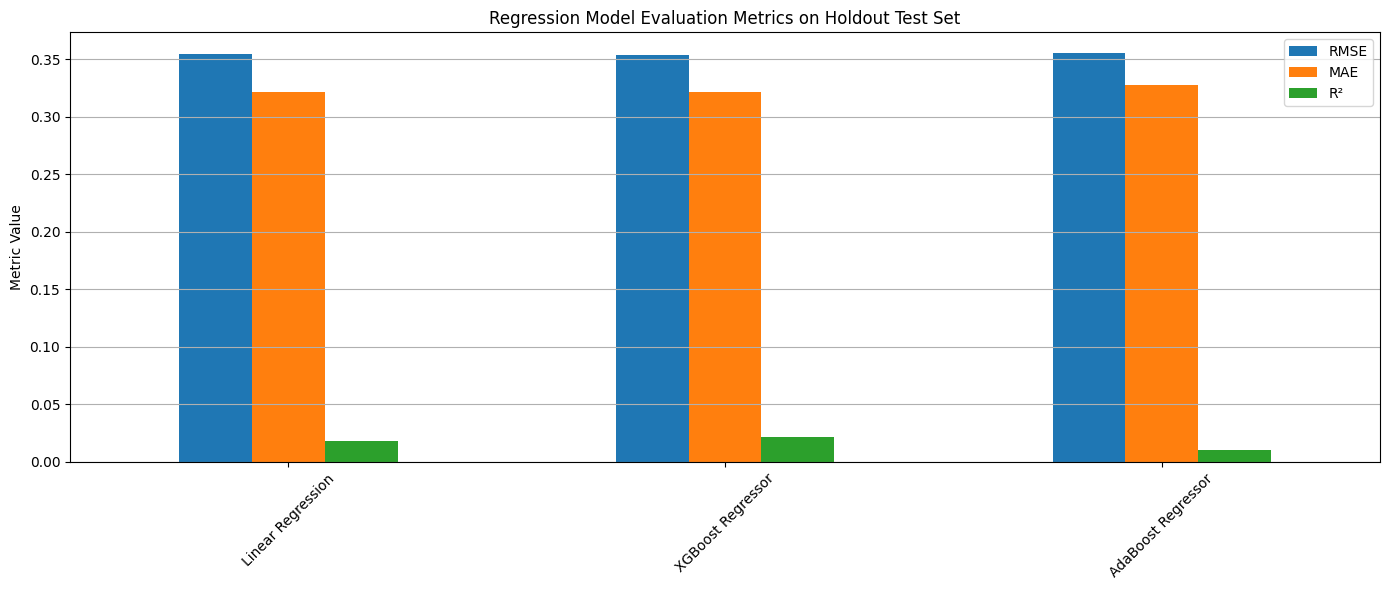

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Main regression metrics to display
main_metrics = ['RMSE', 'MAE', 'R²']

# Plot model performance bar chart
results_df[main_metrics].plot(kind='bar', figsize=(14, 6), rot=45)
plt.title("Regression Model Evaluation Metrics on Holdout Test Set")
plt.ylabel("Metric Value")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


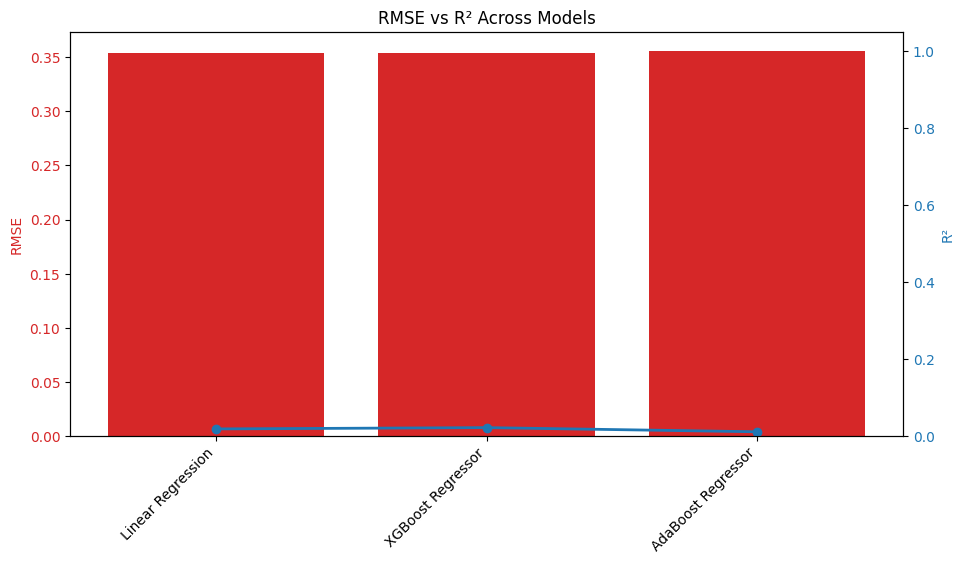

In [32]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:red'
color2 = 'tab:blue'

ax1.set_title("RMSE vs R² Across Models")
ax1.set_ylabel("RMSE", color=color1)
ax1.bar(results_df.index, results_df['RMSE'], color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
ax2.set_ylabel("R²", color=color2)
ax2.plot(results_df.index, results_df['R²'], color=color2, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, 1.05)

# Improve x-axis label formatting
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

fig.tight_layout(pad=2)
plt.show()


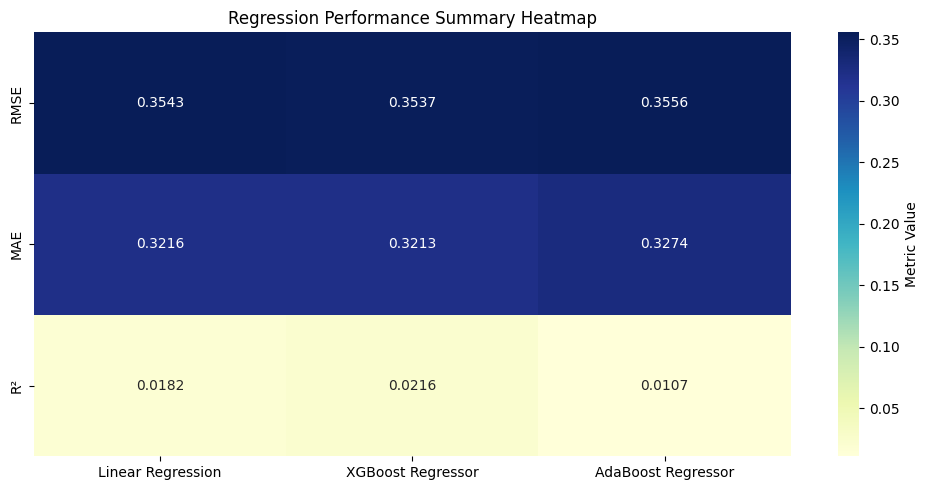

In [33]:
plt.figure(figsize=(10, 5))
sns.heatmap(results_df[main_metrics].T, annot=True, fmt=".4f", cmap="YlGnBu", cbar_kws={'label': 'Metric Value'})
plt.title("Regression Performance Summary Heatmap")
plt.tight_layout()
plt.show()
